[link google pasta com o video](https://drive.google.com/drive/folders/1ETHjkhuD5z-SNjeGEMzfBOAh_BbWaRaz?usp=sharing)

[link google collab](https://colab.research.google.com/drive/1jopR0QX7hSqN_fBMxrno8eYSQcIc13Ws?usp=sharing)


In [13]:
!pip install coppeliasim-zmqremoteapi-client


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import sys

def is_running_in_colab():
    return 'google.colab' in sys.modules


In [2]:
if is_running_in_colab():
    host = '0.tcp.sa.ngrok.io'
    port = 11327  # Substitua com o porto real que o ngrok fornecer
else:
    host = 'localhost'
    port = 23000


In [3]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

try:
    client = RemoteAPIClient(host, port)
    sim = client.getObject('sim')
    print("Conectado a CoppeliaSim vía ZMQ + ngrok")
except Exception as e:
    print(f"Error al conectar: {e}")

Conectado a CoppeliaSim vía ZMQ + ngrok


**Atividade Prática – Geração de Trajetória Linear e Controle de Manipuladores no CopeliaSim**

**Descrição Geral:**

Nesta atividade, o estudante deverá desenvolver um código de controle para um manipulador robótico, com o objetivo de gerar uma trajetória linear no espaço cartesiano, partindo de um ponto A até um ponto B, utilizando uma estratégia de controle de movimento específica e um tipo de manipulador definido conforme as regras abaixo. O robô será simulado no ambiente **CopeliaSim**.

**1. Definição do Manipulador:**

A seleção será feita conforme a seguinte regra:

*   Considere sua matrícula composta por seis dígitos: RSTXYZ.
*   Calcule: Resto de divisão inteira da matrícula por 3: Matrícula % 3.
*   Resultado:

   0 → SCARA

   1 → Cilíndrico

   2 → Esférico ou Polar




Matrícula: 98225

Transformamos para 6 dígitos: 098225

Calculamos:

098225 % 3 = 2

Resultado 2 → Manipulador Esférico ou Polar

**2. Estratégia de Geração de Trajetória:**

Se Z for par → Tempo mínimo (bang-bang).

Se Z for ímpar → Polinomial de 3ª ordem.

O tempo total destinado para execução da trajetória será dado pela soma dos dígitos da matrícula.
 Matrícula: 072943

 Tempo total: 0+7+2+9+4+3 = 25s

Dígito Z é o último da matrícula: 5

Como 5 é ímpar, a estratégia será:

Trajetória polinomial de 3ª ordem

Tempo total da trajetória = soma dos dígitos:

0 + 9 + 8 + 2 + 2 + 5 = 26 segundos

**3. Pontos de Partida e Chegada:**

*   Partida: [-0.5, -0.5, 0.5] m.
*   Chegada: [0.5, 0.5, 1.5] m.
*   Para cada componente, se o dígito correspondente for par, soma-se 0.25, caso contrário, subtrai-se 0.25.
*   NOTA: Caso o ponto de partida, de chegada ou mesmo algum ponto da trajetória de referência apresente alguma restrição quando o movimento do efetuador, por exemplo, colisão com o corpo do robô ou se localizar fora do espaço de trabalho do manipulador, faça a adequação necessária e informe o motivo da alteração.

**Exemplo:**

Matrícula: 072943

*  Ponto A = [-0.5, -0.5, 0.5] + [0.25, -0.25, 0.25] → [-0.25, -0.75, 0.75]
*  Ponto B = [0.5, 0.5, 1.5] + [-0.25, 0.25, -0.25] → [0.25, 0.75, 1.25]

**Referência original:**

*  Partida: [-0.5, -0.5, 0.5]
*  Chegada: [0.5, 0.5, 1.5]

Vamos aplicar a regra dos dígitos para ajustar:

| Componente   | Dígito | Par/Ímpar | Ajuste |
| ------------ | ------ | --------- | ------ |
| x1 (Partida) | 0      | Par       | +0.25  |
| y1           | 9      | Ímpar     | -0.25  |
| z1           | 8      | Par       | +0.25  |
| x2 (Chegada) | 2      | Par       | +0.25  |
| y2           | 2      | Par       | +0.25  |
| z2           | 5      | Ímpar     | -0.25  |

Ponto de partida ajustado:

[-0.5, -0.5, 0.5] + [0.25, -0.25, 0.25]
= [-0.25, -0.75, 0.75] m

Ponto de chegada ajustado:

[0.5, 0.5, 1.5] + [0.25, 0.25, -0.25]
= [0.75, 0.75, 1.25] m


 Resumo Final para a Matrícula ES98225 (098225)
Manipulador: Esférico/Polar

Tipo de trajetória: Polinomial de 3ª ordem

Tempo total: 26 segundos

Ponto de partida: [-0.25, -0.75, 0.75]

Ponto de chegada: [0.75, 0.75, 1.25]

4. Tarefas do Estudante:

*   Calcular o alcance máximo e mínimo do manipulador, representando graficamente.


In [ ]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import math
import numpy as np
import matplotlib.pyplot as plt

def connect_to_coppeliasim():
    client = RemoteAPIClient(host, port)
    sim = client.getObject('sim')
    print('[SUCCESS] Conectado ao CoppeliaSim')
    return sim

def get_esferico_axes(sim):
    axes = {
        'axis1': sim.getObject('/Manipulador/axis1'),  # Rotativo base
        'axis2': sim.getObject('/Manipulador/axis2'),  # Rotativo plano vertical
        'axis3': sim.getObject('/Manipulador/axis3'),  # Linear (alongamento)
    }
    return axes

def generate_workspace(sim, axes, tcp_handle):
    print('[INFO] Iniciando varredura da área de trabalho...')

    theta1_range = np.radians(np.linspace(-180, 180, 10))  # junta
    theta2_range = np.radians(np.linspace(0, 90, 10))  # junta
    d3_range = np.linspace(0.0, 0.5, 10)               # linear

    points = []

    total = len(theta1_range) * len(theta2_range) * len(d3_range)
    count = 0

    for t1 in theta1_range:
        for t2 in theta2_range:
            for d3 in d3_range:
                # Comando de posição
                sim.setJointTargetPosition(axes['axis1'], t1)
                sim.setJointTargetPosition(axes['axis2'], t2)
                sim.setJointTargetPosition(axes['axis3'], d3)
                time.sleep(0.01)

                # Leitura real da posição do TCP
                pose = sim.getObjectPose(tcp_handle, -1)
                position = pose[:3]
                points.append(position)

                count += 1
                if count % 100 == 0:
                    print(f'  - {count}/{total} pontos coletados...')

    return np.array(points)

def plot_workspace(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, alpha=0.5, c='blue')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Área de Trabalho - Leitura Real do TCP')
    plt.tight_layout()
    plt.show()

def main():
    sim = connect_to_coppeliasim()
    scene_path = '/home/usuario/compartilhado/Robotica/Esferico.ttt'
    result = sim.loadScene(scene_path)
    if result == 0:
        raise RuntimeError("Erro ao carregar a cena.")
    print("[SUCCESS] Manipulador carregado com sucesso.")

    sim.startSimulation()
    time.sleep(0.5)

    axes = get_esferico_axes(sim)
    tcp_handle = sim.getObject('/Manipulador/axis4')

    points = generate_workspace(sim, axes, tcp_handle)
    plot_workspace(points)

    sim.stopSimulation()
    print('[DONE] Simulação finalizada.')

if __name__ == "__main__":
    main()



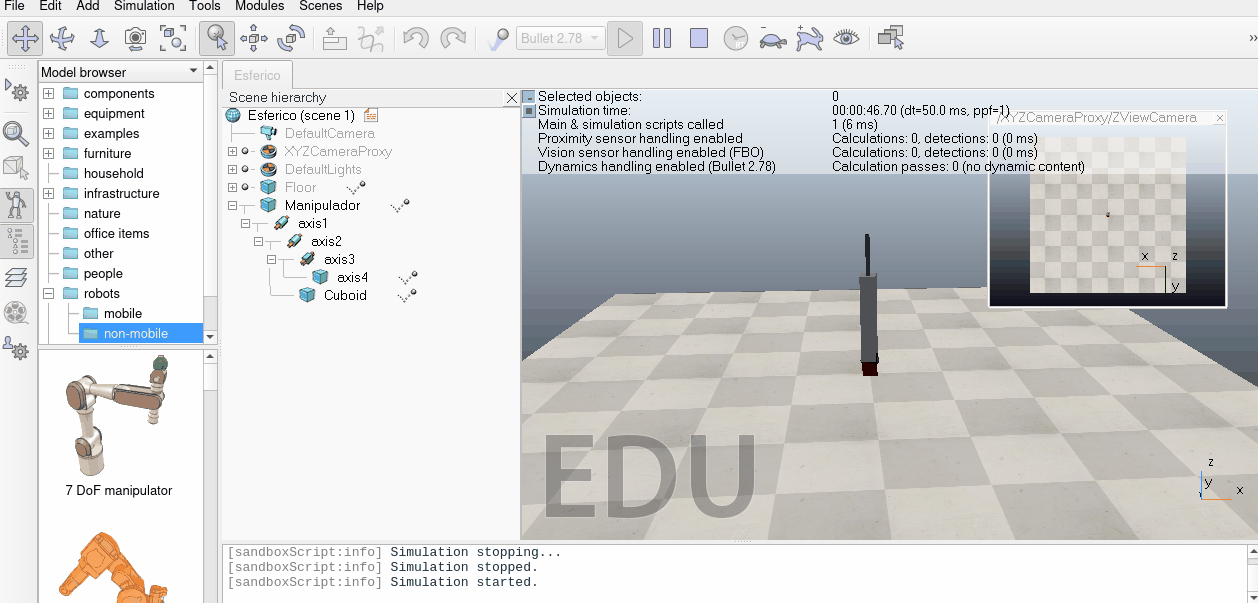

| **Junta**   | **Tipo**                    | **Intervalo de operação**                                           |
|-------------|-----------------------------|----------------------------------------------------------------------|
| $\theta_1$  | Rotação (base)              | $[-\pi, \pi]$ rad ($\approx [-180^\circ, 180^\circ]$)               |
| $\theta_2$  | Rotação (elevação)          | $[0, \frac{\pi}{2}]$ rad ($\approx [0^\circ, 90^\circ]$)            |
| $d_3$       | Prismática (extensão)       | $0.7 + [0.0, 0.5]$ m                                                 |


Cinemática direta (parâmetros DH).

| Junta | Tipo         | Movimento                                                     | Eixo          |
| ----- | ------------ | ------------------------------------------------------------- | ------------- |
| 1     | Revoluta     | $\theta_1$: rotação da base                                   | em torno de Z |
| 2     | Revoluta     | $\theta_2$: inclinação do braço                               | em torno de Y |
| 3     | Prismática   | $d_3$: extensão linear                                        | ao longo de Z |

**parâmetros DH**

| **Junta** | θᵢ     | dᵢ           | aᵢ | αᵢ           |
|----------|--------|---------------|----|---------------|
| 1        | θ₁     | 0             | 0  | π⁄2           |
| 2        | θ₂     | 0             | 0  | −π⁄2          |
| 3        | 0      | L₁ + d₃       | 0  | 0             |




# Interpretação:

Junta 1: gira o braço na base.

Junta 2: inclina o braço

Junta 3: realiza a extensão radial do braço.

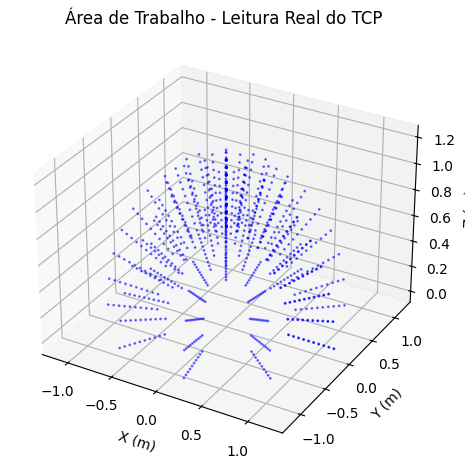

Matrix([
[cos(theta1)*cos(theta2), -sin(theta1), -sin(theta2)*cos(theta1), (-L1 - d3)*sin(theta2)*cos(theta1)],
[sin(theta1)*cos(theta2),  cos(theta1), -sin(theta1)*sin(theta2), (-L1 - d3)*sin(theta1)*sin(theta2)],
[            sin(theta2),            0,              cos(theta2),              (L1 + d3)*cos(theta2)],
[                      0,            0,                        0,                                  1]])

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Variáveis simbólicas
theta1, theta2, d3, L1 = sp.symbols('theta1 theta2 d3 L1')

# Função para gerar matriz DH
def dh(theta, d, a, alpha):
    return sp.Matrix([
        [sp.cos(theta), -sp.sin(theta)*sp.cos(alpha),  sp.sin(theta)*sp.sin(alpha), a*sp.cos(theta)],
        [sp.sin(theta),  sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
        [0,              sp.sin(alpha),               sp.cos(alpha),                d],
        [0,              0,                           0,                            1]
    ])

# Matrizes DH individuais
A1 = dh(theta1, 0,    0,   sp.pi/2)
A2 = dh(theta2, 0,    0,  -sp.pi/2)
A3 = dh(0,      L1 + d3,   0,   0)

# Transformação homogênea total
T = sp.simplify(A1 * A2 * A3)
T

T_func = sp.lambdify((theta1, theta2, d3, L1), T, modules='numpy')


theta1_range = np.radians(np.linspace(-180, 180, 10))  # junta
theta2_range = np.radians(np.linspace(0, 90, 10))  # junta
d3_range = np.linspace(0.0, 0.5, 10)               # linear

points = []

total = len(theta1_range) * len(theta2_range) * len(d3_range)
count = 0

L1_val = 0.7
for t1 in theta1_range:
    for t2 in theta2_range:
        for d3 in d3_range:
            # Comando de posição
            T_numeric  = T_func(t1, t2, d3, L1_val)
            # Extrair posição do efetuador (coluna 4)
            T_np = np.array(T_numeric, dtype=float)
            x, y, z = T_np[0, 3], T_np[1, 3], T_np[2, 3]
            points.append([x, y, z])

points_array = np.array(points)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_array[:, 0], points_array[:, 1], points_array[:, 2], s=1, alpha=0.5, c='blue')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Área de Trabalho - Leitura Real do TCP')
plt.tight_layout()
plt.show()


T

In [ ]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import math
import numpy as np
import matplotlib.pyplot as plt

def connect_to_coppeliasim():
    client = RemoteAPIClient(host, port)
    sim = client.getObject('sim')
    print('[SUCCESS] Conectado ao CoppeliaSim')
    return sim

def get_esferico_axes(sim):
    axes = {
        'axis1': sim.getObject('/Manipulador/axis1'),  # Rotativo base
        'axis2': sim.getObject('/Manipulador/axis2'),  # Rotativo plano vertical
        'axis3': sim.getObject('/Manipulador/axis3'),  # Linear (alongamento)
    }
    return axes

pos_x, pos_y, pos_z = [], [] , []
def registrar_posicao(tcp):
        pose = sim.getObjectPose(tcp, -1)
        pos_x.append(pose[0])
        pos_y.append(pose[1])
        pos_z.append(pose[2])

sim = connect_to_coppeliasim()
scene_path = '/home/usuario/compartilhado/Robotica/Esferico.ttt'
result = sim.loadScene(scene_path)
if result == 0:
    raise RuntimeError("Erro ao carregar a cena.")
print("[SUCCESS] Manipulador carregado com sucesso.")

sim.startSimulation()
time.sleep(0.5)

axes = get_esferico_axes(sim)
tcp_handle = sim.getObject('/Manipulador/axis4')

# 1. Posição inicial
sim.setJointTargetPosition(axes['axis1'], 0)
sim.setJointTargetPosition(axes['axis2'], 0)
sim.setJointTargetPosition(axes['axis3'], 0)
print("Todos os eixos na posição inicial")
time.sleep(1)
registrar_posicao(tcp_handle)

# 2. Movimento 1
sim.setJointTargetPosition(axes['axis1'], 0)
sim.setJointTargetPosition(axes['axis2'], 0)
sim.setJointTargetPosition(axes['axis3'], 0.5)
time.sleep(1)
registrar_posicao(tcp_handle)

#3. Movimento 2
sim.setJointTargetPosition(axes['axis1'], 0)
sim.setJointTargetPosition(axes['axis2'], np.radians(90)) #angulo de elevaco
sim.setJointTargetPosition(axes['axis3'], 0.5)
time.sleep(1)
registrar_posicao(tcp_handle)


#4. Movimento 3
sim.setJointTargetPosition(axes['axis1'], np.radians(180))
sim.setJointTargetPosition(axes['axis2'], np.radians(90)) #angulo de elevaco
sim.setJointTargetPosition(axes['axis3'], 0.5)
time.sleep(1)
registrar_posicao(tcp_handle)


#5. Movimento 4
sim.setJointTargetPosition(axes['axis1'], np.radians(-90))
sim.setJointTargetPosition(axes['axis2'], np.radians(90)) #angulo de elevaco
sim.setJointTargetPosition(axes['axis3'], 0.5)
time.sleep(1)
registrar_posicao(tcp_handle)


#5. Movimento 4
sim.setJointTargetPosition(axes['axis1'], 0)
sim.setJointTargetPosition(axes['axis2'], np.radians(90)) #angulo de elevaco
sim.setJointTargetPosition(axes['axis3'], 0.5)
time.sleep(1)
registrar_posicao(tcp_handle)

# 1. Posição inicial
sim.setJointTargetPosition(axes['axis1'], 0)
sim.setJointTargetPosition(axes['axis2'], 0)
sim.setJointTargetPosition(axes['axis3'], 0)
print("Todos os eixos na posição inicial")
time.sleep(1)
registrar_posicao(tcp_handle)

sim.stopSimulation(tcp_handle)


# Exibir gráfico 3D com os pontos visitados
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_x, pos_y, pos_z, 'k--', label='Trajetória')
ax.scatter(pos_x, pos_y, pos_z, c='r', s=60, label='Posições')

for i, (x, y, z) in enumerate(zip(pos_x, pos_y, pos_z)):
    ax.text(x, y, z, f'{i+1}', fontsize=10, color='blue')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Posições visitadas pelo TCP')
ax.legend()
plt.tight_layout()
plt.show()



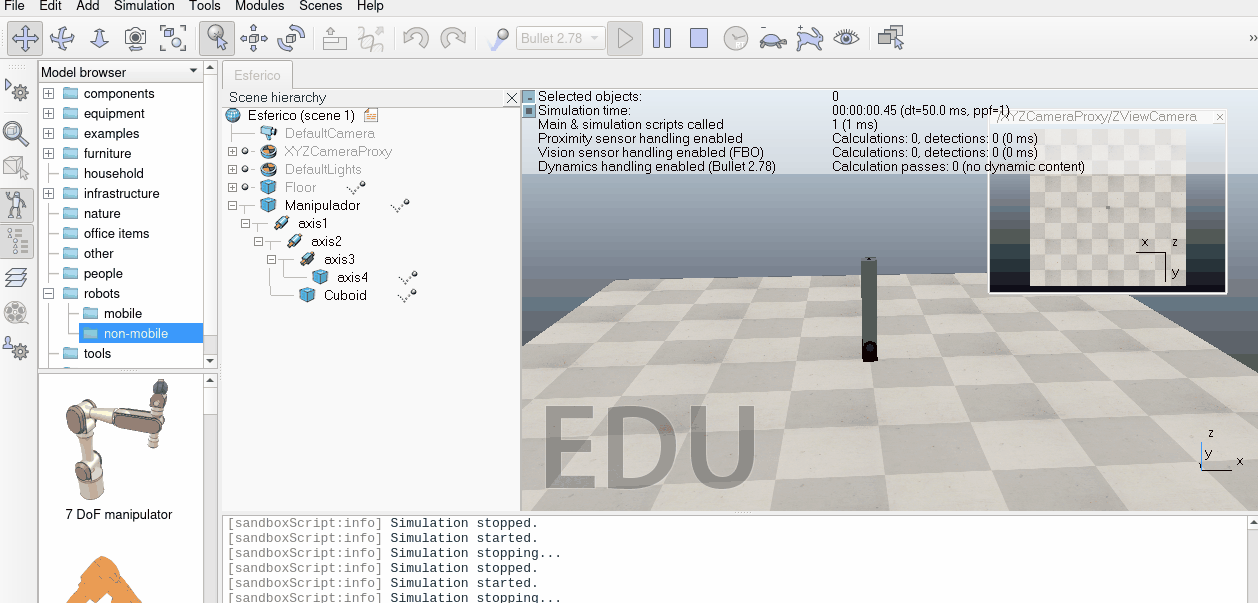


Cinemática inversa (formalismo fornecido).

[-0.25, -0.75, 0.75] m
[0.75, 0.75, 1.25] m

\section*{Cinemática Inversa do Manipulador Esférico}

Para um manipulador com duas juntas revolutas (\(\theta_1\) e \(\theta_2\)) e uma junta prismática (\(d_3\)), a cinemática inversa baseia-se na posição cartesiana \( (x, y, z) \) do efetuador.


\begin{align*}
r &= \sqrt{x^2 + y^2 + z^2} \\
\theta_1 &= \arctan\left(\frac{y}{x}\right) \\
\theta_2 &= \arccos\left(\frac{z}{r}\right) \\
d_3 &= r - L_1
\end{align*}

In [ ]:
import numpy as np

def cinem_inversa(x, y, z, L1):
    r = np.sqrt(x**2 + y**2 + z**2)

    # Evitar divisões por zero
    if r < 1e-6:
        raise ValueError("Raio muito pequeno, posição inválida.")

    theta1 = np.arctan2(y, x)
    theta2 = np.arccos(z / r)
    d3 = r - L1
    return theta1, theta2, d3

In [ ]:

x, y, z = -0.25, -0.75, 0.75
L1 = 0.7
theta1, theta2, d3 = cinem_inversa(x, y, z, L1)

print("θ₁ (graus):", np.degrees(theta1))
print("θ₂ (graus):", np.degrees(theta2))
print("d₃ (m):", d3)

θ₁ (graus): -108.43494882292202
θ₂ (graus): 46.508480654908006
d₃ (m): 0.38972473588516854


In [ ]:
x, y, z = 0.75, 0.75, 1.25
L1 = 0.7
theta1, theta2, d3 = cinem_inversa(x, y, z, L1)

print("θ₁ (graus):", np.degrees(theta1))
print("θ₂ (graus):", np.degrees(theta2))
print("d₃ (m):", d3)

θ₁ (graus): 45.0
θ₂ (graus): 40.31554221077258
d₃ (m): 0.9393596310755001


Geração de trajetória conforme a estratégia.


[SUCCESS] Conectado ao CoppeliaSim
[INFO] Simulação finalizada.


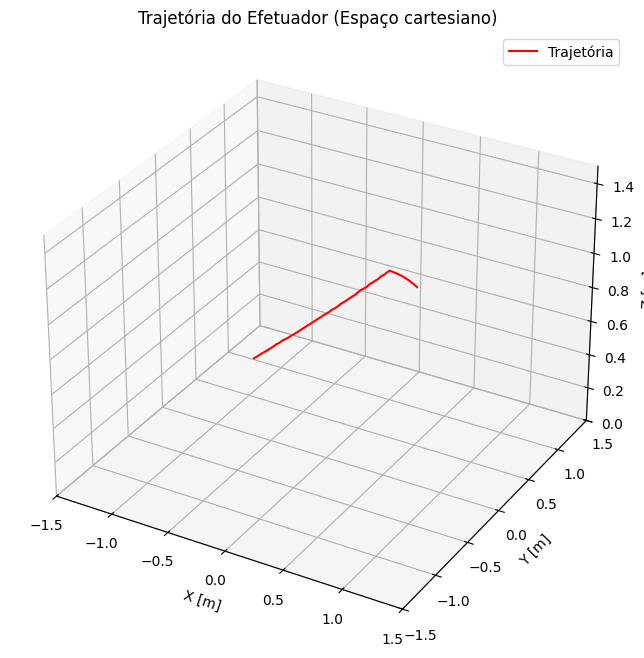

In [ ]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import math
import numpy as np
import matplotlib.pyplot as plt

matricula = "98225"
matricula = matricula.zfill(6)
R, S, T, X, Y, Z = map(int, matricula)

# Estratégia
if Z % 2 == 0:
    estrategia = "bang-bang"
else:
    estrategia = "polinomial"

partida = [-0.5, -0.5, 0.5]
chegada = [0.5, 0.5, 1.5]

ajuste_A = [0.25 if d % 2 == 0 else -0.25 for d in [R, S, T]]
ajuste_B = [0.25 if d % 2 == 0 else -0.25 for d in [X, Y, Z]]

ponto_A = [p + a for p, a in zip(partida, ajuste_A)]
ponto_B = [p + b for p, b in zip(chegada, ajuste_B)]

# Tempo total
tf = R + S + T + X + Y + Z

# Conectar com o simulador
sim = connect_to_coppeliasim()
sim.startSimulation()
time.sleep(0.5)

axes = get_esferico_axes(sim)
tcp_handle = sim.getObject('/Manipulador/axis4')

L1 = 0.7  # comprimento fixo

# Levar ao ponto inicial
x0, y0, z0 = ponto_A
xf, yf, zf = ponto_B
theta1, theta2, d3 = cinem_inversa(x0, y0, z0, L1)
sim.setJointTargetPosition(axes['axis1'], theta1)
sim.setJointTargetPosition(axes['axis2'], theta2)
sim.setJointTargetPosition(axes['axis3'], d3)
time.sleep(2)

# Preparar dados
visited_x, visited_y, visited_z = [], [], []

n_frames = 100
for i in range(n_frames + 1):
    t = i * tf / n_frames
    alpha = 3*(t/tf)**2 - 2*(t/tf)**3  # interpolação polinomial

    x = x0 + alpha * (xf - x0)
    y = y0 + alpha * (yf - y0)
    z = z0 + alpha * (zf - z0)

    try:
        theta1, theta2, d3 = cinem_inversa(x, y, z, L1)
        sim.setJointTargetPosition(axes['axis1'], theta1)
        sim.setJointTargetPosition(axes['axis2'], theta2)
        sim.setJointTargetPosition(axes['axis3'], d3)

        # Obter posição real
        pose = sim.getObjectPose(tcp_handle, -1)
        visited_x.append(pose[0])
        visited_y.append(pose[1])
        visited_z.append(pose[2])

        time.sleep(tf / n_frames)

    except Exception as e:
        print(f"[ERRO] Frame {i}: {e}")



sim.stopSimulation()
print("[INFO] Simulação finalizada.")

# Plot final
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(visited_x, visited_y, visited_z, 'r-', label="Trajetória")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([0, 1.5])
ax.set_title("Trajetória do Efetuador (Espaço cartesiano)")
ax.grid(True)
ax.legend()
plt.show()



[SUCCESS] Conectado ao CoppeliaSim
[INFO] Levadando o manipulador para a posição inicial:  [-0.25, -0.75, 0.75]
[INFO] Estratégia polinomial configurada para um tempo total de 26 segundos.
[INFO] Iniciando reta no espaço até a posição final:  [0.75, 0.75, 1.25]
[INFO] Simulação finalizada.


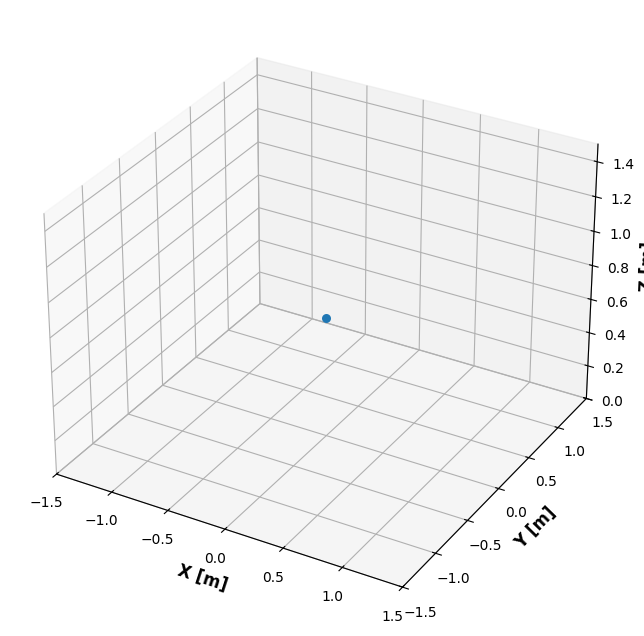

In [17]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation


def setup_plot():
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X [m]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y [m]', fontsize=12, fontweight='bold')
    ax.set_zlabel('Z [m]', fontsize=12, fontweight='bold')
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([0, 1.5])
    ax.grid(True)
    return fig, ax

def connect_to_coppeliasim():
    client = RemoteAPIClient(host,port)
    sim = client.getObject('sim')
    print('[SUCCESS] Conectado ao CoppeliaSim')
    return sim

def get_esferico_axes(sim):
    axes = {
        'axis1': sim.getObject('/Manipulador/axis1'),  # Rotativo base
        'axis2': sim.getObject('/Manipulador/axis2'),  # Rotativo plano vertical
        'axis3': sim.getObject('/Manipulador/axis3'),  # Linear (alongamento)
    }
    return axes

def cinem_inversa(x, y, z, L1 = 0.7):
    r = np.sqrt(x**2 + y**2 + z**2)

    # Evitar divisões por zero
    if r < 1e-6:
        raise ValueError("Raio muito pequeno, posição inválida.")

    theta1 = np.arctan2(y, x)
    theta2 = np.arccos(z / r)
    d3 = r - L1
    return theta1, theta2, d3


matricula = "98225"
matricula = matricula.zfill(6)
R, S, T, X, Y, Z = map(int, matricula)

# Estratégia
if Z % 2 == 0:
    estrategia = "bang-bang"
else:
    estrategia = "polinomial"

partida = [-0.5, -0.5, 0.5]
chegada = [0.5, 0.5, 1.5]

ajuste_A = [0.25 if d % 2 == 0 else -0.25 for d in [R, S, T]]
ajuste_B = [0.25 if d % 2 == 0 else -0.25 for d in [X, Y, Z]]

ponto_A = [p + a for p, a in zip(partida, ajuste_A)]
ponto_B = [p + b for p, b in zip(chegada, ajuste_B)]

# Tempo total
tf = R + S + T + X + Y + Z

# Conectar com o simulador
sim = connect_to_coppeliasim()
sim.startSimulation()
time.sleep(0.5)

axes = get_esferico_axes(sim)
tcp_handle = sim.getObject('/Manipulador/axis4')

L1 = 0.7  # comprimento fixo

  # Configuração inicial
fig, ax = setup_plot()
trajectory_line, = ax.plot([], [], [], 'k-', linewidth=2)
visited_x, visited_y, visited_z = [], [], []
current_pos_marker = ax.scatter([], [], [], 'r--', linewidth=2)

# Levar ao ponto inicial
x0, y0, z0 = ponto_A
xf, yf, zf = ponto_B

# Mover para posição inicial
print('[INFO] Levadando o manipulador para a posição inicial: ', ponto_A)


theta1, theta2, d3 = cinem_inversa(x0, y0, z0, L1)
sim.setJointTargetPosition(axes['axis1'], theta1)
sim.setJointTargetPosition(axes['axis2'], theta2)
sim.setJointTargetPosition(axes['axis3'], d3)
time.sleep(2)

# Preparar dados
print('[INFO] Estratégia %s configurada para um tempo total de %d segundos.' %(estrategia, tf))
print('[INFO] Iniciando reta no espaço até a posição final: ', ponto_B)

tempos = []
posicoes = []
juntas = []
def update(frame):
        alpha = 3*(frame/tf)**2 - 2*(frame/tf)**3  # Interpolação polinomial

        # Calcular posição desejada
        x = x0 + alpha*(xf - x0)
        y = y0 + alpha*(yf - y0)
        z = z0 + alpha*(zf - z0)

        try:
            # Cinemática inversa e controle
            theta1, theta2, d3 = cinem_inversa(x, y, z)
            sim.setJointTargetPosition(axes['axis1'], theta1)
            sim.setJointTargetPosition(axes['axis2'], theta2)
            sim.setJointTargetPosition(axes['axis3'], d3)

            # Obter posição atual
            pose = sim.getObjectPosition(tcp_handle, -1)
            joint1 = sim.getJointPosition(axes['axis1'])
            joint2 = sim.getJointPosition(axes['axis2'])
            joint3 = sim.getJointPosition(axes['axis3'])
            current_pos = pose

            # Atualizar plot
            trajectory_line.set_data([x0, x], [y0, y])
            trajectory_line.set_3d_properties([z0, z])

            visited_x.append(current_pos[0])
            visited_y.append(current_pos[1])
            visited_z.append(current_pos[2])

            current_pos_marker._offsets3d = ([current_pos[0]], [current_pos[1]], [current_pos[2]])
            posicoes.append(pose[:3])
            juntas.append([joint1, joint2, joint3])
            tempos.append(frame)

        except Exception as e:
            print(f"Erro: {e}")

        return trajectory_line, current_pos_marker

# Criar animação
ani = FuncAnimation(fig, update, frames=np.linspace(0, tf, 100),
                    interval=50, blit=False, repeat=False)

# Salvar como vídeo ou GIF
ani.save("trajetoria.gif", writer='pillow', fps=20)
fig.savefig("trajetoria_final.png", dpi=300, bbox_inches='tight')
sim.stopSimulation()
print("[INFO] Simulação finalizada.")




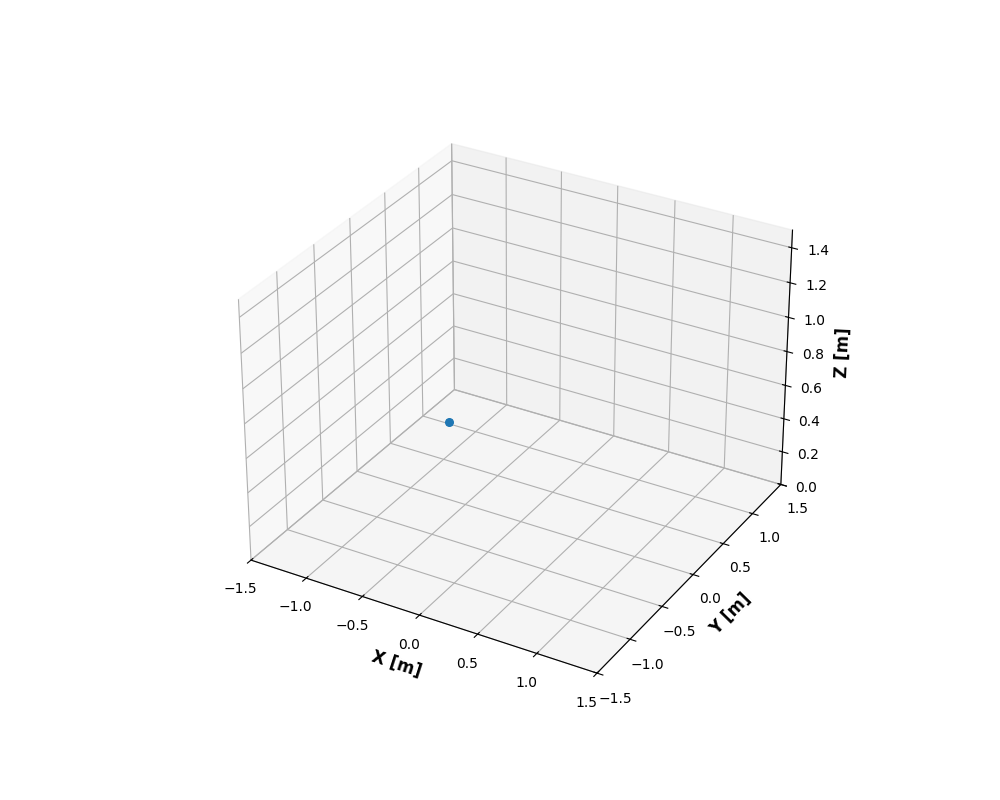

In [ ]:
from IPython.display import Image
Image(filename="trajetoria.gif")


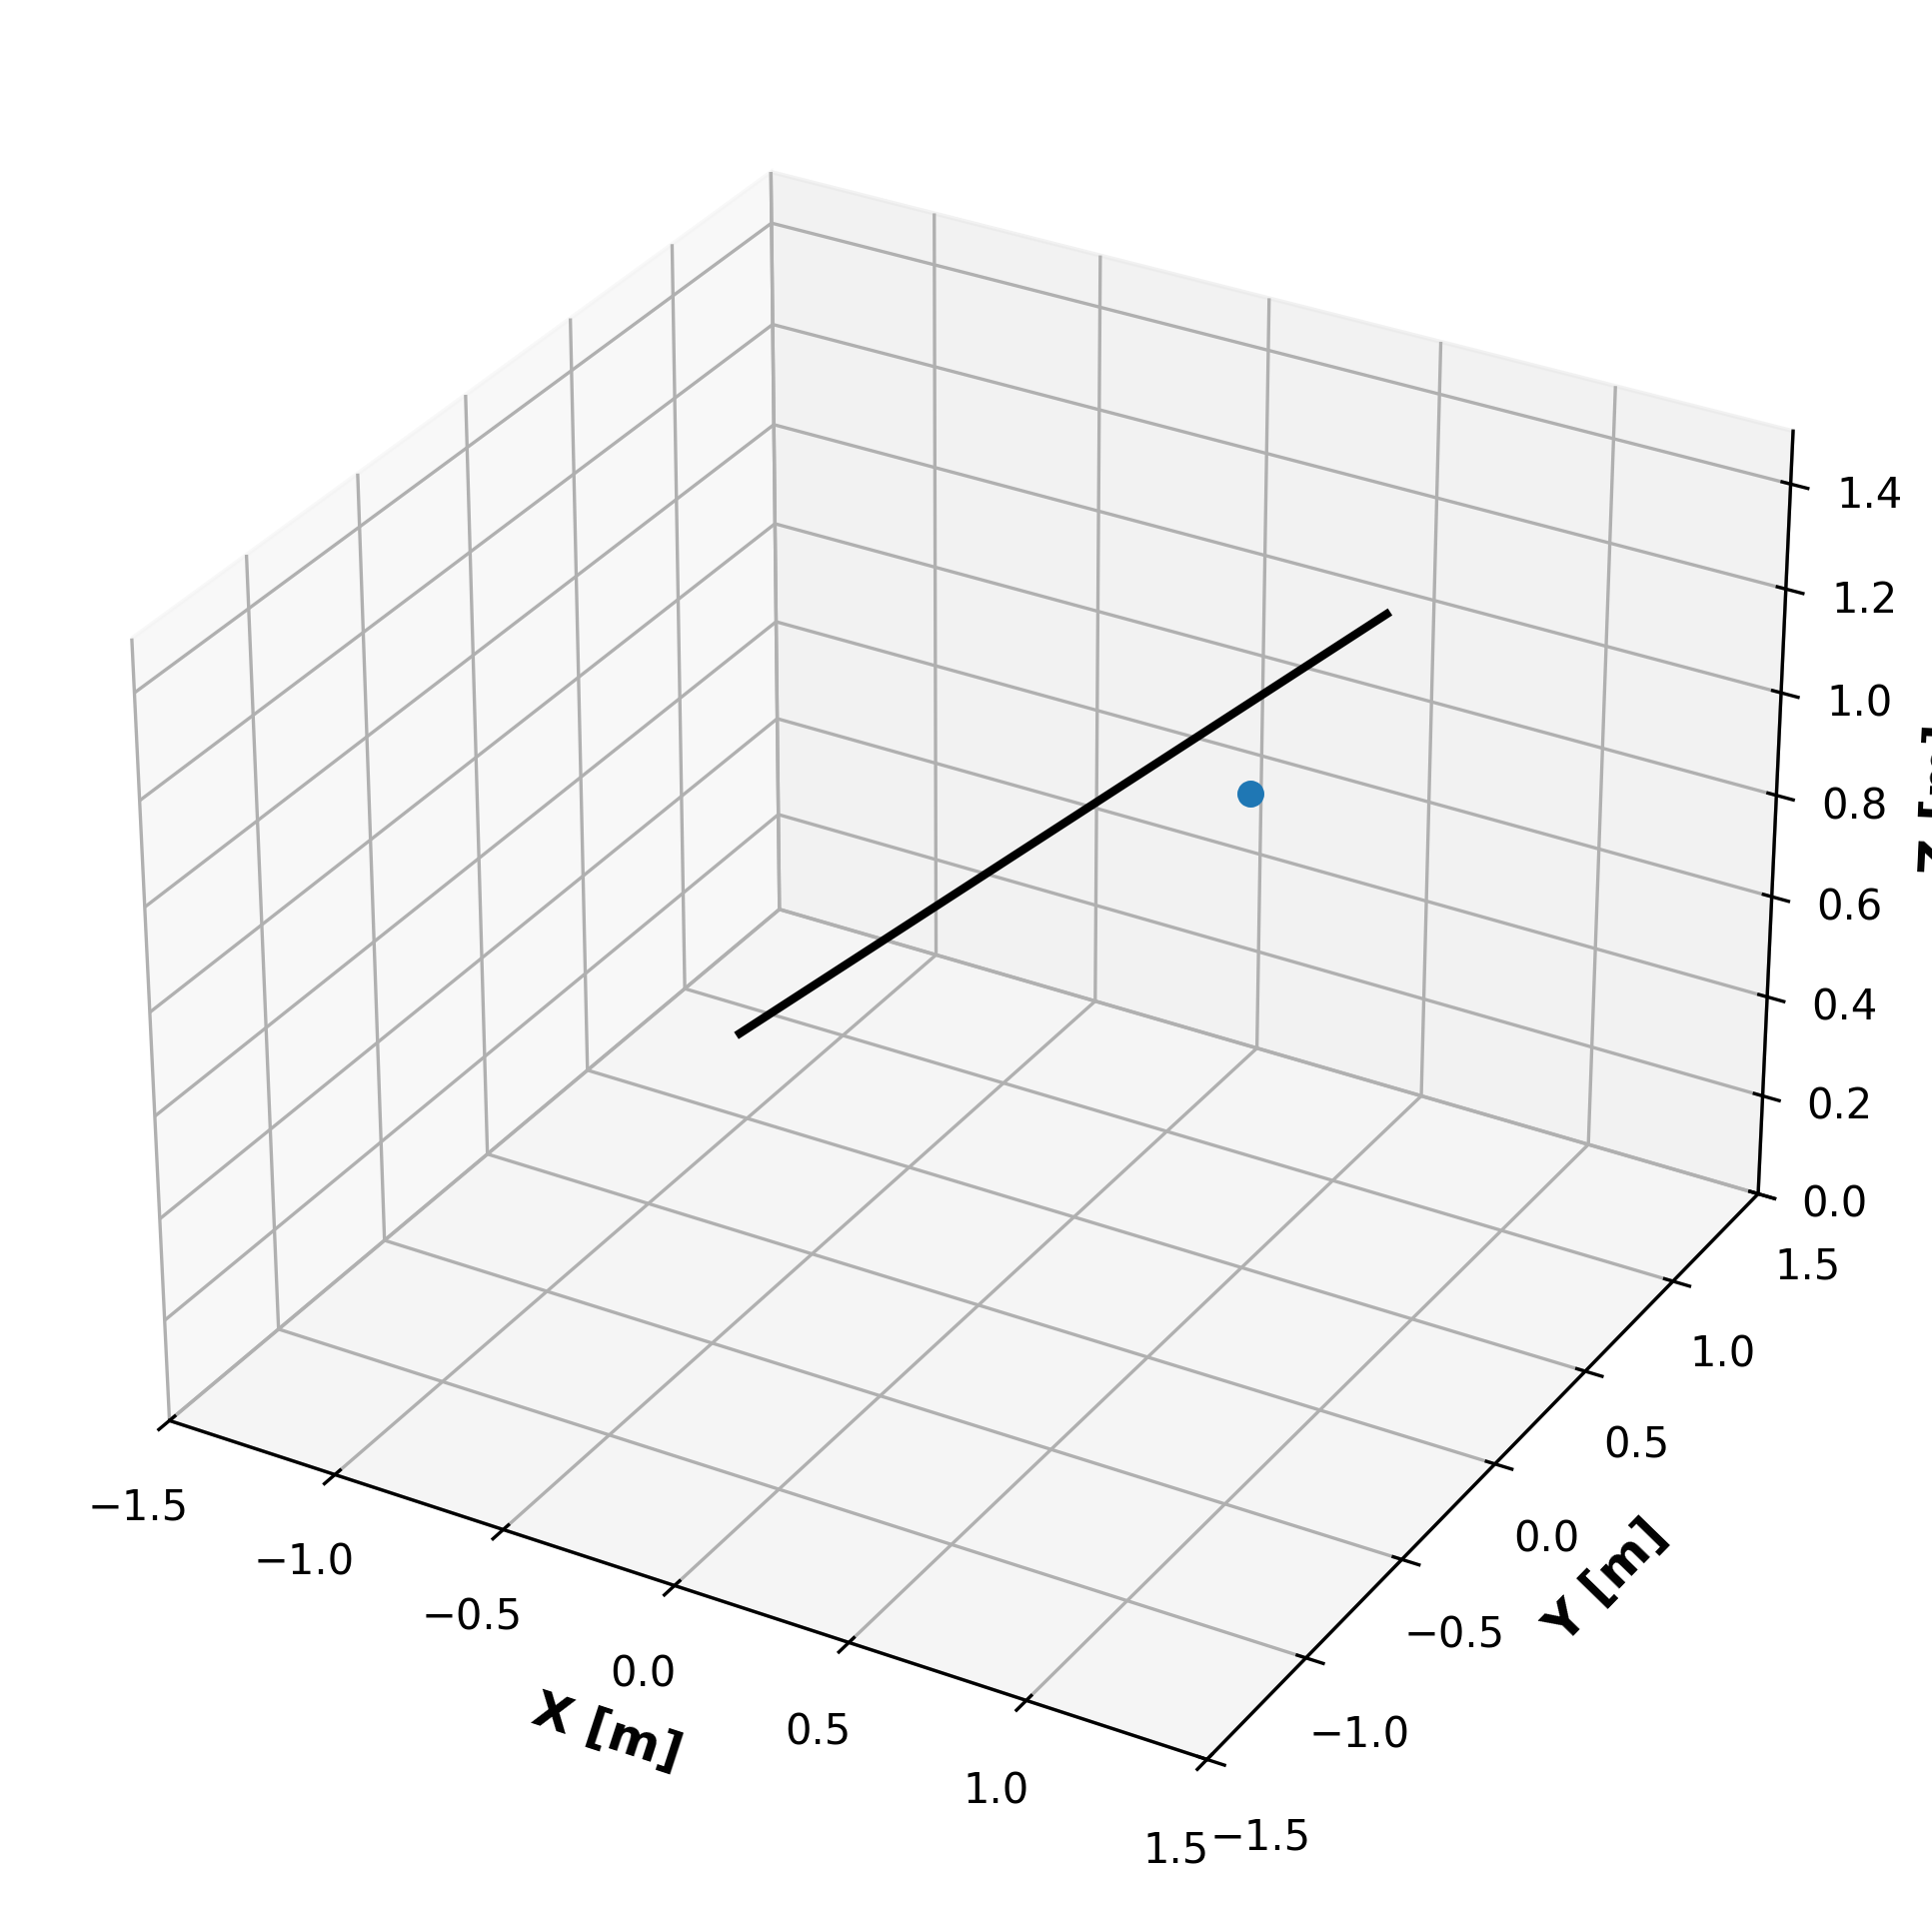

In [ ]:
from IPython.display import Image
Image(filename="trajetoria_final.png")

Gerar gráficos:

Posição do efetuador ao longo do tempo.

Velocidade do efetuador ao longo do tempo.

Posição angular ou deslocamento linear das juntas.


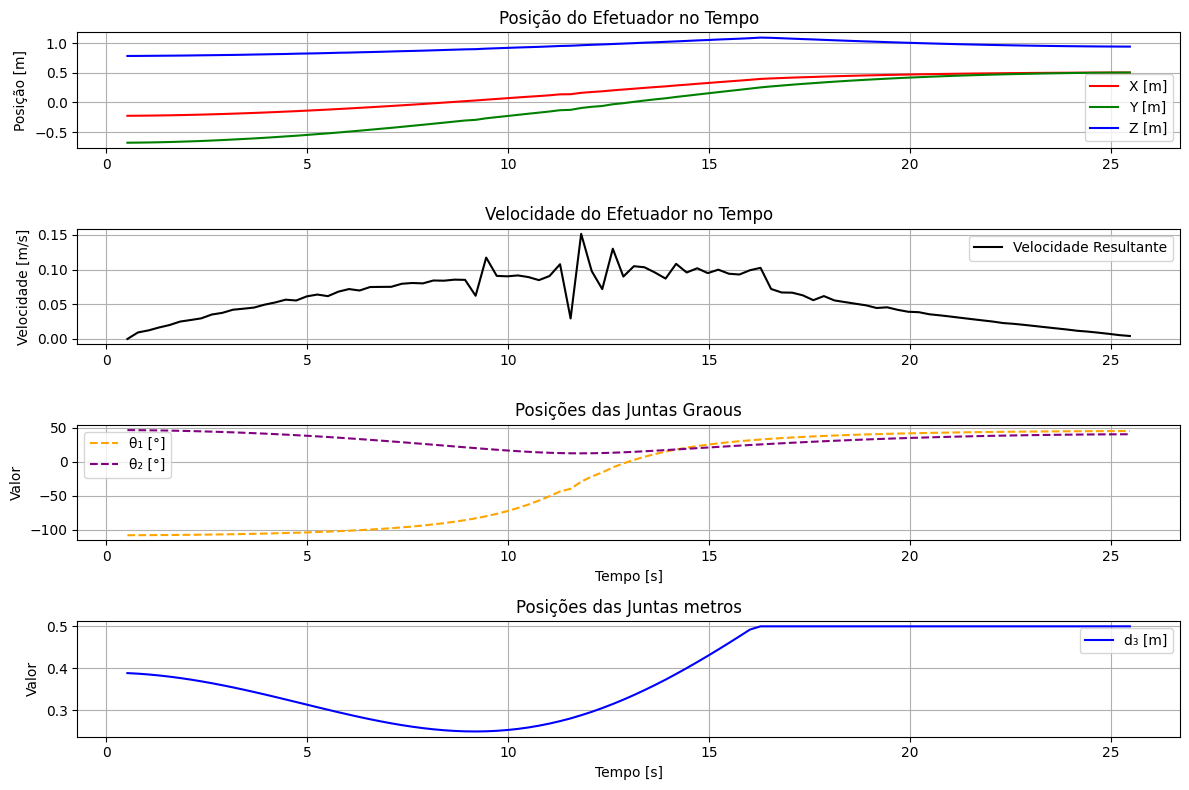

In [20]:
# ======= Processamento =======
tempos = np.array(tempos)
posicoes = np.array(posicoes)
juntas = np.array(juntas)


tempos = tempos[1:-1]
posicoes = posicoes[1:-1]
juntas = juntas[1:-1]

# Calcular velocidades por diferenças finitas
velocidades = np.zeros_like(posicoes)
for i in range(1, len(tempos)):
    dt = tempos[i] - tempos[i-1]
    velocidades[i] = (posicoes[i] - posicoes[i-1]) / dt

v_resultante = np.linalg.norm(velocidades, axis=1)

# ======= Plot 1: Posição do efetuador =======
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(tempos, posicoes[:, 0], label='X [m]', color='r')
plt.plot(tempos, posicoes[:, 1], label='Y [m]', color='g')
plt.plot(tempos, posicoes[:, 2], label='Z [m]', color='b')
plt.title('Posição do Efetuador no Tempo')
plt.ylabel('Posição [m]')
plt.grid(True)
plt.legend()

# ======= Plot 2: Velocidade do efetuador =======
plt.subplot(4, 1, 2)
plt.plot(tempos, v_resultante, label='Velocidade Resultante', color='black')
plt.title('Velocidade do Efetuador no Tempo')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)
plt.legend()

# ======= Plot 3: Juntas =======
plt.subplot(4, 1, 3)
plt.plot(tempos, np.degrees(juntas[:, 0]), label='θ₁ [°]', linestyle='--', color='orange')
plt.plot(tempos, np.degrees(juntas[:, 1]), label='θ₂ [°]', linestyle='--', color='purple')
#plt.plot(tempos, juntas[:, 2], label='d₃ [m]', linestyle='-', color='blue')
plt.title('Posições das Juntas Graous')
plt.xlabel('Tempo [s]')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()

# ======= Plot 3: Juntas =======
plt.subplot(4, 1, 4)
#plt.plot(tempos, np.degrees(juntas[:, 0]), label='θ₁ [°]', linestyle='--', color='orange')
#plt.plot(tempos, np.degrees(juntas[:, 1]), label='θ₂ [°]', linestyle='--', color='purple')
plt.plot(tempos, juntas[:, 2], label='d₃ [m]', linestyle='-', color='blue')
plt.title('Posições das Juntas metros')
plt.xlabel('Tempo [s]')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

[INFO] Conectado ao CoppeliaSim com sucesso.
[INFO] Iniciando execução da trajetória...
[INFO] Simulação finalizada.


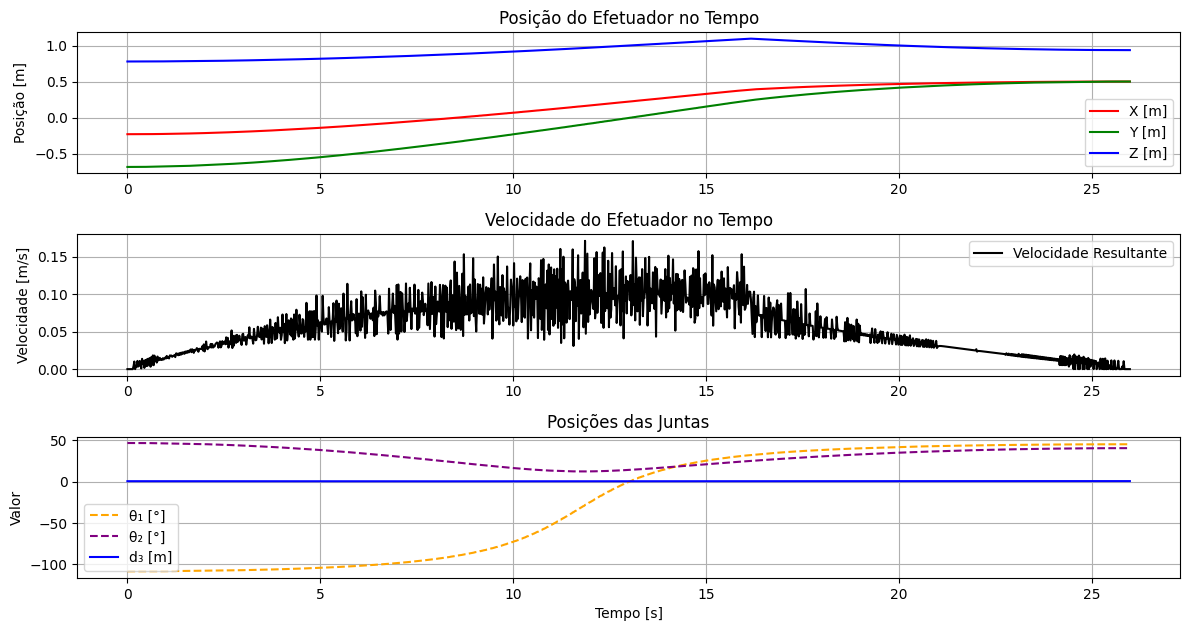

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# ======= Conectar ao CoppeliaSim =======
client = RemoteAPIClient(host, port)
sim = client.getObject('sim')
print("[INFO] Conectado ao CoppeliaSim com sucesso.")

# ======= Handles das juntas =======
handles = {
    'j1': sim.getObject('/Manipulador/axis1'),
    'j2': sim.getObject('/Manipulador/axis2'),
    'j3': sim.getObject('/Manipulador/axis3'),
    'tcp': sim.getObject('/Manipulador/axis4'),
}

# ======= Cinemática Inversa =======
def cinem_inversa(x, y, z, L1=0.7):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta1 = np.arctan2(y, x)
    theta2 = np.arccos(z / r)
    d3 = r - L1
    return theta1, theta2, d3


# ======= Parâmetros da trajetória =======
ponto_A = [-0.25, -0.75, 0.75]
ponto_B =  [0.75, 0.75, 1.25]
x0, y0, z0 = ponto_A
xf, yf, zf = ponto_B
L1 = 0.7
tf = 26  # tempo total (s)
fps = 50
n_frames = tf * fps

# ======= Iniciar simulação e ir para ponto inicial =======
sim.startSimulation()
time.sleep(1)

theta1, theta2, d3 = cinem_inversa(x0, y0, z0, L1)
sim.setJointTargetPosition(handles['j1'], theta1)
sim.setJointTargetPosition(handles['j2'], theta2)
sim.setJointTargetPosition(handles['j3'], d3)
time.sleep(2)

# ======= Coleta de dados =======
tempos = []
posicoes = []
juntas = []

print("[INFO] Iniciando execução da trajetória...")
start = time.time()
for i in range(n_frames):
    t = i / fps
    alpha = 3*(t/tf)**2 - 2*(t/tf)**3

    # Ponto atual da interpolação
    x = x0 + alpha * (xf - x0)
    y = y0 + alpha * (yf - y0)
    z = z0 + alpha * (zf - z0)

    # Inversa + envio
    theta1, theta2, d3 = cinem_inversa(x, y, z, L1)
    sim.setJointTargetPosition(handles['j1'], theta1)
    sim.setJointTargetPosition(handles['j2'], theta2)
    sim.setJointTargetPosition(handles['j3'], d3)

    # Espera para simular tempo real
    time.sleep(1/fps)
    #time.sleep(0.2)
    # Coletar dados
    tcp_pos = sim.getObjectPosition(handles['tcp'], -1)
    joint1 = sim.getJointPosition(handles['j1'])
    joint2 = sim.getJointPosition(handles['j2'])
    joint3 = sim.getJointPosition(handles['j3'])

    tempos.append(t)
    posicoes.append(tcp_pos)
    juntas.append([joint1, joint2, joint3])

sim.stopSimulation()
print("[INFO] Simulação finalizada.")

# ======= Processamento =======
tempos = np.array(tempos)
posicoes = np.array(posicoes)
juntas = np.array(juntas)

# Calcular velocidades por diferenças finitas
velocidades = np.zeros_like(posicoes)
for i in range(1, len(tempos)):
    dt = tempos[i] - tempos[i-1]
    velocidades[i] = (posicoes[i] - posicoes[i-1]) / dt

v_resultante = np.linalg.norm(velocidades, axis=1)

# ======= Plot 1: Posição do efetuador =======
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(tempos, posicoes[:, 0], label='X [m]', color='r')
plt.plot(tempos, posicoes[:, 1], label='Y [m]', color='g')
plt.plot(tempos, posicoes[:, 2], label='Z [m]', color='b')
plt.title('Posição do Efetuador no Tempo')
plt.ylabel('Posição [m]')
plt.grid(True)
plt.legend()

# ======= Plot 2: Velocidade do efetuador =======
plt.subplot(4, 1, 2)
plt.plot(tempos, v_resultante, label='Velocidade Resultante', color='black')
plt.title('Velocidade do Efetuador no Tempo')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)
plt.legend()

# ======= Plot 3: Juntas =======
plt.subplot(4, 1, 3)
plt.plot(tempos, np.degrees(juntas[:, 0]), label='θ₁ [°]', linestyle='--', color='orange')
plt.plot(tempos, np.degrees(juntas[:, 1]), label='θ₂ [°]', linestyle='--', color='purple')
#plt.plot(tempos, juntas[:, 2], label='d₃ [m]', linestyle='-', color='blue')
plt.title('Posições das Juntas')
plt.xlabel('Tempo [s]')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()


# ======= Plot 4: Juntas =======
plt.subplot(4, 1, 3)
#plt.plot(tempos, np.degrees(juntas[:, 0]), label='θ₁ [°]', linestyle='--', color='orange')
#plt.plot(tempos, np.degrees(juntas[:, 1]), label='θ₂ [°]', linestyle='--', color='purple')
plt.plot(tempos, juntas[:, 2], label='d₃ [m]', linestyle='-', color='blue')
plt.title('Posições das Juntas')
plt.xlabel('Tempo [s]')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
